# Environment

In [175]:
import pandas as pd
import numpy as np
import ddfloww as dd
import scipy as sp
import scipy.stats as stats
import xgboost as xgb
import statsmodels.api as sm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.feature_selection import f_regression



# Acquisition

Created four dataframes of properties and predictions (2016 & 2017). Joined them into a single dataframe which was exported to a csv file in order to facilitate working locally on a single machine. The previous operations ran once and then commented out. The function below reads in the saved `zillow.csv` file.

In [176]:
df = dd.get_zillow()

# Preparation

In [177]:
# Plot styling
plt.style.use('fivethirtyeight')

Let's take a peek at the dataframe and summarize.

In [178]:
dd.summarize_data(df)
df.shape

HEAD
   parcelid  logerror transactiondate       id  airconditioningtypeid  \
0  11016594    0.0276      2016-01-01  2931667                    1.0   
1  14366692   -0.1684      2016-01-01   475764                    NaN   
2  12098116   -0.0040      2016-01-01  2444575                    1.0   
3  12643413    0.0218      2016-01-02  1584730                    1.0   
4  14432541   -0.0050      2016-01-02  2926916                    NaN   

   architecturalstyletypeid  basementsqft  bathroomcnt  bedroomcnt  \
0                       NaN           NaN          2.0         3.0   
1                       NaN           NaN          3.5         4.0   
2                       NaN           NaN          3.0         2.0   
3                       NaN           NaN          2.0         2.0   
4                       NaN           NaN          2.5         4.0   

   buildingclasstypeid         ...           taxdelinquencyflag  \
0                  NaN         ...                          NaN   
1

parcelid:
(10554760.42, 26409495.9]     167841
(26409495.9, 42107253.8]           0
(42107253.8, 57805011.7]           0
(57805011.7, 73502769.6]           0
(73502769.6, 89200527.5]           1
(89200527.5, 104898285.4]          4
(104898285.4, 120596043.3]         0
(120596043.3, 136293801.2]         0
(136293801.2, 151991559.1]         0
(151991559.1, 167689317.0]        42
Name: parcelid, dtype: int64


logerror:
(-4.666, -3.664]         6
(-3.664, -2.672]         4
(-2.672, -1.68]         83
(-1.68, -0.688]        364
(-0.688, 0.304]     163696
(0.304, 1.296]        3417
(1.296, 2.287]         197
(2.287, 3.279]         111
(3.279, 4.271]           6
(4.271, 5.263]           4
Name: logerror, dtype: int64


transactiondate:
2017-06-30    1195
2017-04-28     917
2016-07-29     910
2016-04-29     902
2016-09-30     894
2016-06-30     874
2017-05-31     868
2016-05-27     863
2017-07-28     815
2017-08-31     782
2017-03-31     772
2017-05-26     746
2016-08-31     737
2016-07-01    

longitude:
(-119477336.781, -119283338.0]      455
(-119283338.0, -119091260.0]       4364
(-119091260.0, -118899182.0]       3169
(-118899182.0, -118707104.0]       5860
(-118707104.0, -118515026.0]      12716
(-118515026.0, -118322948.0]      33176
(-118322948.0, -118130870.0]      32895
(-118130870.0, -117938792.0]      31196
(-117938792.0, -117746714.0]      27647
(-117746714.0, -117554636.0]      16376
Name: longitude, dtype: int64


lotsizesquarefeet:
(-6803.844, 697251.3]     148831
(697251.3, 1394335.6]        497
(1394335.6, 2091419.9]        75
(2091419.9, 2788504.2]         3
(2788504.2, 3485588.5]         1
(3485588.5, 4182672.8]        24
(4182672.8, 4879757.1]         0
(4879757.1, 5576841.4]         0
(5576841.4, 6273925.7]         0
(6273925.7, 6971010.0]        15
Name: lotsizesquarefeet, dtype: int64


poolcnt:
NaN     133813
 1.0     34075
Name: poolcnt, dtype: int64


poolsizesum:
(22.273, 196.6]      15
(196.6, 369.2]      178
(369.2, 541.8]      979
(541.8, 714.4]

NaN                                                                                                                                                                                                                                        167857
Buildings having wood or wood and steel frames                                                                                                                                                                                                 30
Buildings having exterior walls built of a non-combustible material such as brick, concrete, block or poured concrete. Interior partitions and roof structures are built of combustible materials. Floor may be concrete or wood frame.         1
Name: buildingclassdesc, dtype: int64


propertylandusedesc:
Single Family Residential                     113078
Condominium                                    42157
Duplex (2 Units, Any Combination)               4397
Planned Unit Development                        4281
Q

(167888, 68)

Aggressively reduce number of column variables:

1. Columns and (subsequently) rows were removed if their number of missing values exceeds the threshold of 50% for columns and 75% for rows.
1. Columns that are redundant or add no value were also removed.
1. Certain rows were removed if the given columns' values are null.
1. Estimated single-unit dwellings were estimated and filtered in.

In [179]:
df = dd.prep_zillow(df,
                    preq_col=.5,
                    preq_row=.6,
                    cols_to_remove=['parcelid',
                                    'id',
                                    'finishedsquarefeet12',
                                    'fips',
                                    'heatingorsystemtypeid',
                                    'propertylandusetypeid',
                                    'rawcensustractandblock',
                                    'regionidcity',
                                    'roomcnt',
                                    'assessmentyear',
                                    'censustractandblock',
                                    'structuretaxvaluedollarcnt',
                                    'taxvaluedollarcnt',
                                    'propertycountylandusecode',
                                    'propertycountylandusecode',
                                    'propertylandusetypeid',
                                    'propertyzoningdesc',],
                    cols_to_validate=['latitude', 'longitude'])

Impute the values in land square feet using linear regression with landtaxvaluedollarcnt as x and estimated land square feet as y.

In [180]:
# Take the absolute value of log errors
df.logerror = df.logerror.abs()
df.logerror.sample(10)

89930     0.099800
131107    0.155381
54641     0.031500
126869    0.198612
146992    0.002401
28154     0.191200
146842    0.027532
13865     0.035400
54570     0.015100
132861    0.212232
Name: logerror, dtype: float64

In [181]:
df = dd.impute_missing(df)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[32683.87758287]
[[-0.01046837]]
Univariate - final_exam = b + m * exam1
    y-intercept (b): 32683.88
    coefficient (m): -0.01



In [182]:
dd.missing_values_col(df)

num_missing  missing_percentage  num_empty  \
logerror                                0            0.000000          0   
transactiondate                         0            0.000000          0   
bathroomcnt                             0            0.000000          0   
bedroomcnt                              0            0.000000          0   
buildingqualitytypeid               56590           34.809620          0   
calculatedbathnbr                     112            0.068893          0   
calculatedfinishedsquarefeet           26            0.015993          0   
fullbathcnt                           112            0.068893          0   
latitude                                0            0.000000          0   
longitude                               0            0.000000          0   
lotsizesquarefeet                       0            0.000000          0   
regionidcounty                          0            0.000000          0   
regionidzip                            58            0.035677          0   
unitcnt                             55366           34.056714          0   
yearbuilt                             133            0.081811          0   
landtaxvaluedollarcnt                   2            0.001230          0   
taxamount                              11            0.006766          0   
propertylandusedesc                     0            0.000000          0   
heatingorsystemdesc                 57129           35.141170          0   

                              empty_percentage  nan_count  nan_percentage  
logerror                                   0.0          0             0.0  
transactiondate                            0.0          0             0.0  
bathroomcnt                                0.0          0             0.0  
bedroomcnt                                 0.0          0             0.0  
buildingqualitytypeid                      0.0          0             0.0  
calculatedbathnbr                          0.0          0             0.0  
calculatedfinishedsquarefeet               0.0          0             0.0  
fullbathcnt                                0.0          0             0.0  
latitude                                   0.0          0             0.0  
longitude                                  0.0          0             0.0  
lotsizesquarefeet                          0.0          0             0.0  
regionidcounty                             0.0          0             0.0  
regionidzip                                0.0          0             0.0  
unitcnt                                    0.0          0             0.0  
yearbuilt                                  0.0          0             0.0  
landtaxvaluedollarcnt                      0.0          0             0.0  
taxamount                                  0.0          0             0.0  
propertylandusedesc                        0.0          0             0.0  
heatingorsystemdesc                        0.0          0             0.0

In [183]:
df = dd.fill_with_median(df, ['buildingqualitytypeid', 'unitcnt', 'yearbuilt'])

In [184]:
df = dd.fill_with_none(df, 'heatingorsystemdesc')

In [185]:
dd.missing_values_col(df)

num_missing  missing_percentage  num_empty  \
logerror                                0            0.000000          0   
transactiondate                         0            0.000000          0   
bathroomcnt                             0            0.000000          0   
bedroomcnt                              0            0.000000          0   
buildingqualitytypeid                   0            0.000000          0   
calculatedbathnbr                     112            0.068893          0   
calculatedfinishedsquarefeet           26            0.015993          0   
fullbathcnt                           112            0.068893          0   
latitude                                0            0.000000          0   
longitude                               0            0.000000          0   
lotsizesquarefeet                       0            0.000000          0   
regionidcounty                          0            0.000000          0   
regionidzip                            58            0.035677          0   
unitcnt                                 0            0.000000          0   
yearbuilt                               0            0.000000          0   
landtaxvaluedollarcnt                   2            0.001230          0   
taxamount                              11            0.006766          0   
propertylandusedesc                     0            0.000000          0   
heatingorsystemdesc                     0            0.000000          0   

                              empty_percentage  nan_count  nan_percentage  
logerror                                   0.0          0             0.0  
transactiondate                            0.0          0             0.0  
bathroomcnt                                0.0          0             0.0  
bedroomcnt                                 0.0          0             0.0  
buildingqualitytypeid                      0.0          0             0.0  
calculatedbathnbr                          0.0          0             0.0  
calculatedfinishedsquarefeet               0.0          0             0.0  
fullbathcnt                                0.0          0             0.0  
latitude                                   0.0          0             0.0  
longitude                                  0.0          0             0.0  
lotsizesquarefeet                          0.0          0             0.0  
regionidcounty                             0.0          0             0.0  
regionidzip                                0.0          0             0.0  
unitcnt                                    0.0          0             0.0  
yearbuilt                                  0.0          0             0.0  
landtaxvaluedollarcnt                      0.0          0             0.0  
taxamount                                  0.0          0             0.0  
propertylandusedesc                        0.0          0             0.0  
heatingorsystemdesc                        0.0          0             0.0

In [186]:
dd.missing_values_row(df)

num_missing  percentage
0                 0         0.0
1                 0         0.0
2                 0         0.0
3                 0         0.0
4                 0         0.0
5                 0         0.0
6                 0         0.0
7                 0         0.0
8                 0         0.0
9                 0         0.0
10                0         0.0
11                0         0.0
12                0         0.0
13                0         0.0
14                0         0.0
15                0         0.0
16                0         0.0
17                0         0.0
18                0         0.0
19                0         0.0
20                0         0.0
21                0         0.0
22                0         0.0
23                0         0.0
24                0         0.0
25                0         0.0
26                0         0.0
27                0         0.0
28                0         0.0
29                0         0.0
...             ...         ...
167857            0         0.0
167858            0         0.0
167859            0         0.0
167860            0         0.0
167861            0         0.0
167862            0         0.0
167863            0         0.0
167864            0         0.0
167865            0         0.0
167866            0         0.0
167867            0         0.0
167868            0         0.0
167869            0         0.0
167870            0         0.0
167871            0         0.0
167873            0         0.0
167874            0         0.0
167875            0         0.0
167876            0         0.0
167877            0         0.0
167878            0         0.0
167879            0         0.0
167880            0         0.0
167881            0         0.0
167882            0         0.0
167883            0         0.0
167884            0         0.0
167885            0         0.0
167886            0         0.0
167887            0         0.0

[162570 rows x 2 columns]

Let's check data types.

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162570 entries, 0 to 167887
Data columns (total 19 columns):
logerror                        162570 non-null float64
transactiondate                 162570 non-null object
bathroomcnt                     162570 non-null float64
bedroomcnt                      162570 non-null float64
buildingqualitytypeid           162570 non-null float64
calculatedbathnbr               162458 non-null float64
calculatedfinishedsquarefeet    162544 non-null float64
fullbathcnt                     162458 non-null float64
latitude                        162570 non-null float64
longitude                       162570 non-null float64
lotsizesquarefeet               162570 non-null float64
regionidcounty                  162570 non-null float64
regionidzip                     162512 non-null float64
unitcnt                         162570 non-null float64
yearbuilt                       162570 non-null float64
landtaxvaluedollarcnt           162568 non-null fl

Convert column variables into their proper data type.

In [188]:
df = dd.convert_to_string(df,
                          'buildingqualitytypeid',
                          'regionidcounty',
                          'regionidzip',)

In [189]:
df = dd.convert_to_int(df, 'yearbuilt')

Check colummn variables for the correct data type after `astype()` conversions.

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162570 entries, 0 to 167887
Data columns (total 19 columns):
logerror                        162570 non-null float64
transactiondate                 162570 non-null object
bathroomcnt                     162570 non-null float64
bedroomcnt                      162570 non-null float64
buildingqualitytypeid           162570 non-null object
calculatedbathnbr               162458 non-null float64
calculatedfinishedsquarefeet    162544 non-null float64
fullbathcnt                     162458 non-null float64
latitude                        162570 non-null float64
longitude                       162570 non-null float64
lotsizesquarefeet               162570 non-null float64
regionidcounty                  162570 non-null object
regionidzip                     162570 non-null object
unitcnt                         162570 non-null float64
yearbuilt                       162570 non-null int64
landtaxvaluedollarcnt           162568 non-null float64

Now, let's check for some outliers.

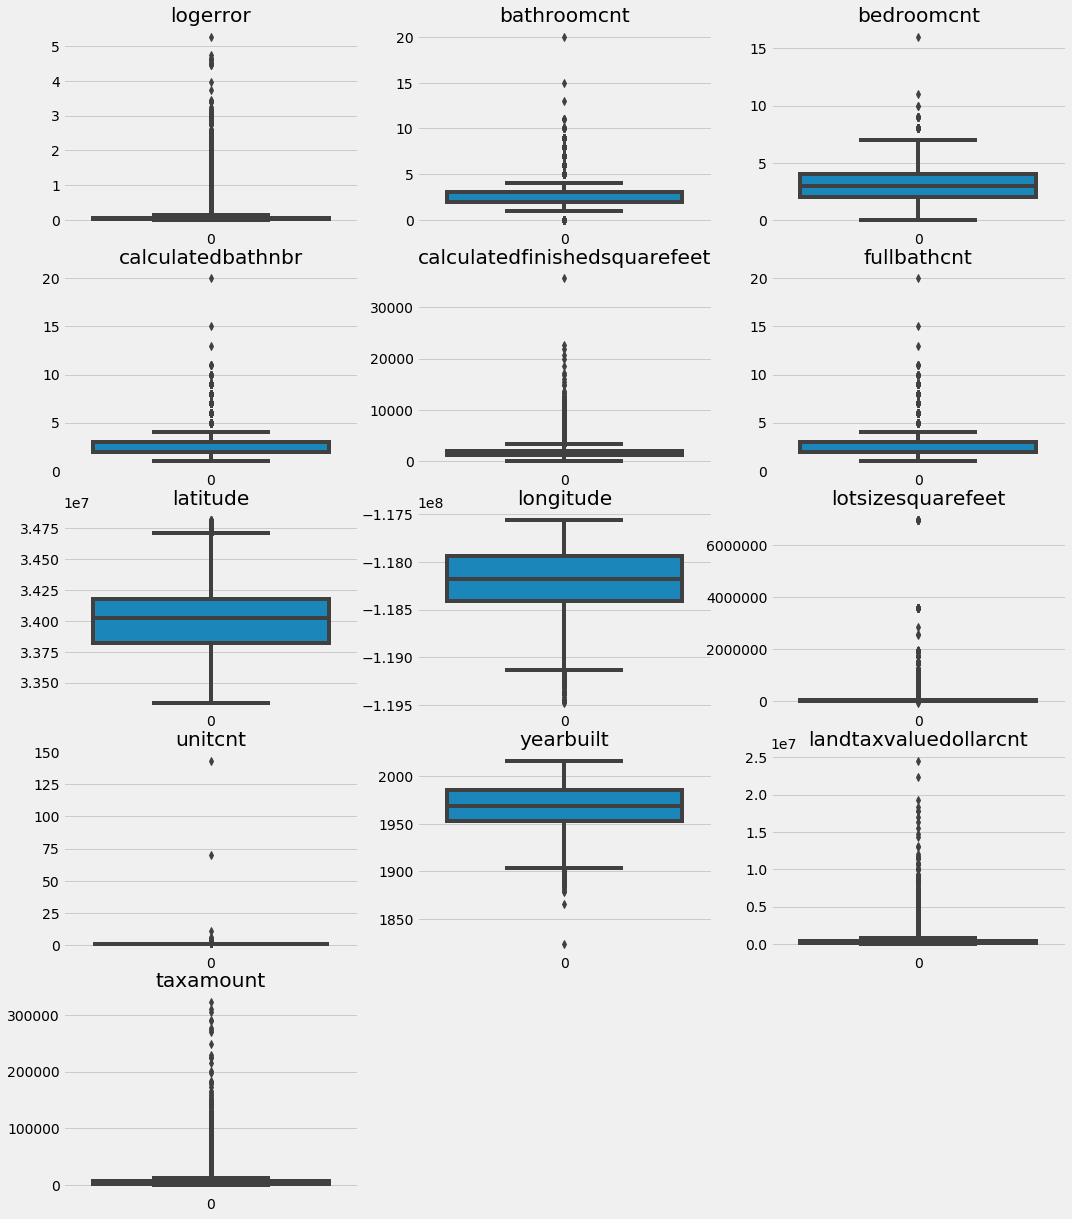

In [191]:
dd.plot_subs(df,
             df.select_dtypes(include='number').columns.values)

Now, let's remove the outliers.

In [192]:
# Remove outliers and nonsensical observations
# TODO: do this using function with selectable method.
df = df[df.bathroomcnt <= 15]
df = df[df.bedroomcnt <= 13]
df = df[df.calculatedbathnbr <= 15]
df = df[df.calculatedfinishedsquarefeet <= 14000]
df = df[df.fullbathcnt <= 15]
df = df[df.latitude >= 33500000]
df = df[df.lotsizesquarefeet <= 2000000]
df = df[df.unitcnt <= 1]
df = df[df.landtaxvaluedollarcnt <= 20000000]

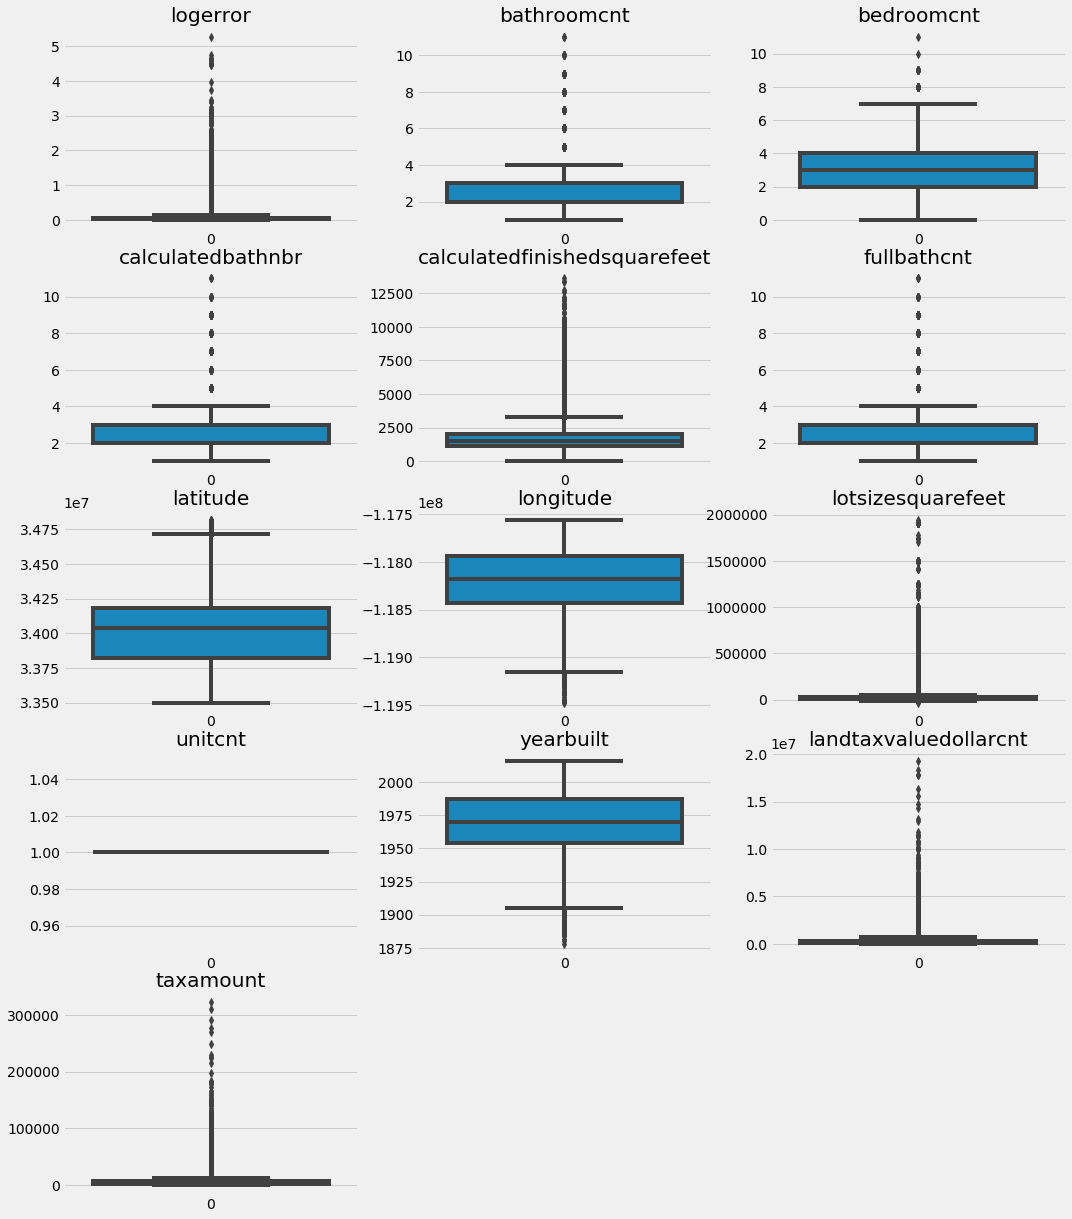

In [193]:
dd.plot_subs(df,
             df.select_dtypes(include='number').columns.values)

'unitcnt' can now be removed since all observations share the same value.

In [194]:
df = df.drop(columns='unitcnt')
df.columns

Index(['logerror', 'transactiondate', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fullbathcnt', 'latitude', 'longitude',
       'lotsizesquarefeet', 'regionidcounty', 'regionidzip', 'yearbuilt',
       'landtaxvaluedollarcnt', 'taxamount', 'propertylandusedesc',
       'heatingorsystemdesc'],
      dtype='object')

In [195]:
dd.missing_values_col(df)

num_missing  missing_percentage  num_empty  \
logerror                                0             0.00000          0   
transactiondate                         0             0.00000          0   
bathroomcnt                             0             0.00000          0   
bedroomcnt                              0             0.00000          0   
buildingqualitytypeid                   0             0.00000          0   
calculatedbathnbr                       0             0.00000          0   
calculatedfinishedsquarefeet            0             0.00000          0   
fullbathcnt                             0             0.00000          0   
latitude                                0             0.00000          0   
longitude                               0             0.00000          0   
lotsizesquarefeet                       0             0.00000          0   
regionidcounty                          0             0.00000          0   
regionidzip                             0             0.00000          0   
yearbuilt                               0             0.00000          0   
landtaxvaluedollarcnt                   0             0.00000          0   
taxamount                              10             0.00647          0   
propertylandusedesc                     0             0.00000          0   
heatingorsystemdesc                     0             0.00000          0   

                              empty_percentage  nan_count  nan_percentage  
logerror                                   0.0          0        0.000000  
transactiondate                            0.0          0        0.000000  
bathroomcnt                                0.0          0        0.000000  
bedroomcnt                                 0.0          0        0.000000  
buildingqualitytypeid                      0.0          0        0.000000  
calculatedbathnbr                          0.0          0        0.000000  
calculatedfinishedsquarefeet               0.0          0        0.000000  
fullbathcnt                                0.0          0        0.000000  
latitude                                   0.0          0        0.000000  
longitude                                  0.0          0        0.000000  
lotsizesquarefeet                          0.0          0        0.000000  
regionidcounty                             0.0          0        0.000000  
regionidzip                                0.0         58        0.037527  
yearbuilt                                  0.0          0        0.000000  
landtaxvaluedollarcnt                      0.0          0        0.000000  
taxamount                                  0.0          0        0.000000  
propertylandusedesc                        0.0          0        0.000000  
heatingorsystemdesc                        0.0          0        0.000000

In [196]:
df = dd.validate_cols(df, ['taxamount'])

In [197]:
dd.missing_values_col(df)

num_missing  missing_percentage  num_empty  \
logerror                                0                 0.0          0   
transactiondate                         0                 0.0          0   
bathroomcnt                             0                 0.0          0   
bedroomcnt                              0                 0.0          0   
buildingqualitytypeid                   0                 0.0          0   
calculatedbathnbr                       0                 0.0          0   
calculatedfinishedsquarefeet            0                 0.0          0   
fullbathcnt                             0                 0.0          0   
latitude                                0                 0.0          0   
longitude                               0                 0.0          0   
lotsizesquarefeet                       0                 0.0          0   
regionidcounty                          0                 0.0          0   
regionidzip                             0                 0.0          0   
yearbuilt                               0                 0.0          0   
landtaxvaluedollarcnt                   0                 0.0          0   
taxamount                               0                 0.0          0   
propertylandusedesc                     0                 0.0          0   
heatingorsystemdesc                     0                 0.0          0   

                              empty_percentage  nan_count  nan_percentage  
logerror                                   0.0          0         0.00000  
transactiondate                            0.0          0         0.00000  
bathroomcnt                                0.0          0         0.00000  
bedroomcnt                                 0.0          0         0.00000  
buildingqualitytypeid                      0.0          0         0.00000  
calculatedbathnbr                          0.0          0         0.00000  
calculatedfinishedsquarefeet               0.0          0         0.00000  
fullbathcnt                                0.0          0         0.00000  
latitude                                   0.0          0         0.00000  
longitude                                  0.0          0         0.00000  
lotsizesquarefeet                          0.0          0         0.00000  
regionidcounty                             0.0          0         0.00000  
regionidzip                                0.0         58         0.03753  
yearbuilt                                  0.0          0         0.00000  
landtaxvaluedollarcnt                      0.0          0         0.00000  
taxamount                                  0.0          0         0.00000  
propertylandusedesc                        0.0          0         0.00000  
heatingorsystemdesc                        0.0          0         0.00000

# Exploration

Let's plot the logerror and its distribution.

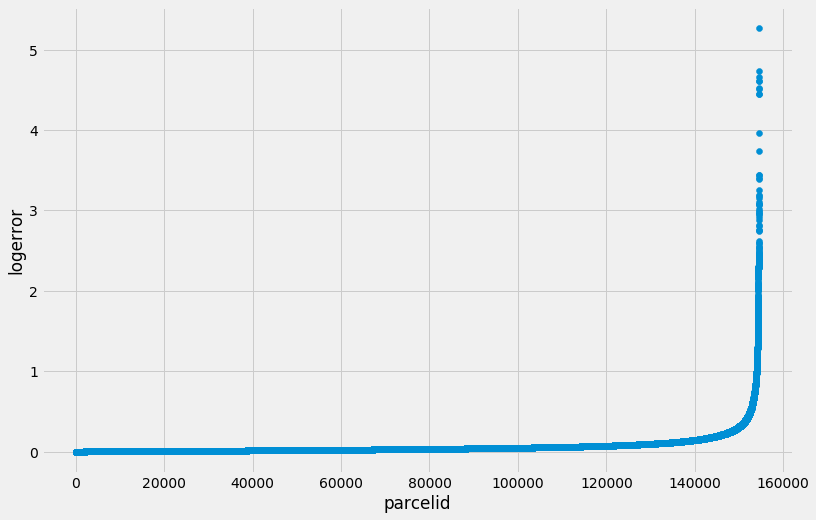

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


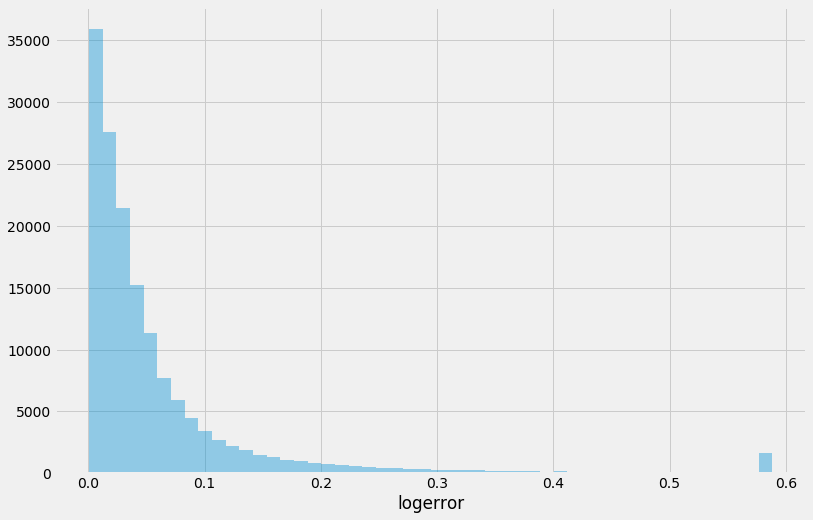

In [198]:
# Plot the log error
plt.figure(figsize=(12,8))
plt.scatter(range(df.shape[0]), np.sort(df.logerror.values))
plt.xlabel('parcelid')
plt.ylabel('logerror')
plt.show()

# Remove outliers
ulimit = np.percentile(df.logerror.values, 99)
llimit = np.percentile(df.logerror.values, 1)
df['logerror'].loc[df['logerror']>ulimit] = ulimit
df['logerror'].loc[df['logerror']<llimit] = llimit

# Plot the distribution
plt.figure(figsize=(12,8))
sns.distplot(df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror')
plt.show()

In [199]:
df.columns

Index(['logerror', 'transactiondate', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fullbathcnt', 'latitude', 'longitude',
       'lotsizesquarefeet', 'regionidcounty', 'regionidzip', 'yearbuilt',
       'landtaxvaluedollarcnt', 'taxamount', 'propertylandusedesc',
       'heatingorsystemdesc'],
      dtype='object')

Let's create a variable to hold a list of numerical variables.

In [200]:
num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols

['logerror',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'fullbathcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'yearbuilt',
 'landtaxvaluedollarcnt',
 'taxamount']

Let's create a variable to hold a list of non-numerical variables.

In [201]:
cat_cols = df.select_dtypes(exclude='number').columns.tolist()
cat_cols

['transactiondate',
 'buildingqualitytypeid',
 'regionidcounty',
 'regionidzip',
 'propertylandusedesc',
 'heatingorsystemdesc']

Let's save a copy of the dataframe before standardizing.

In [202]:
df_normal = df.copy()

Let's use minmax scaling to standardize applicable variables.

In [203]:
df = dd.standardize_data(df, columns=['logerror',
                                      'bathroomcnt',
                                      'bedroomcnt',
                                      'calculatedbathnbr',
                                      'calculatedfinishedsquarefeet',
                                      'latitude',
                                      'longitude',
                                      'lotsizesquarefeet',
                                      'yearbuilt',
                                      'landtaxvaluedollarcnt',
                                      'taxamount'])

Let's see the distribution of some variables.

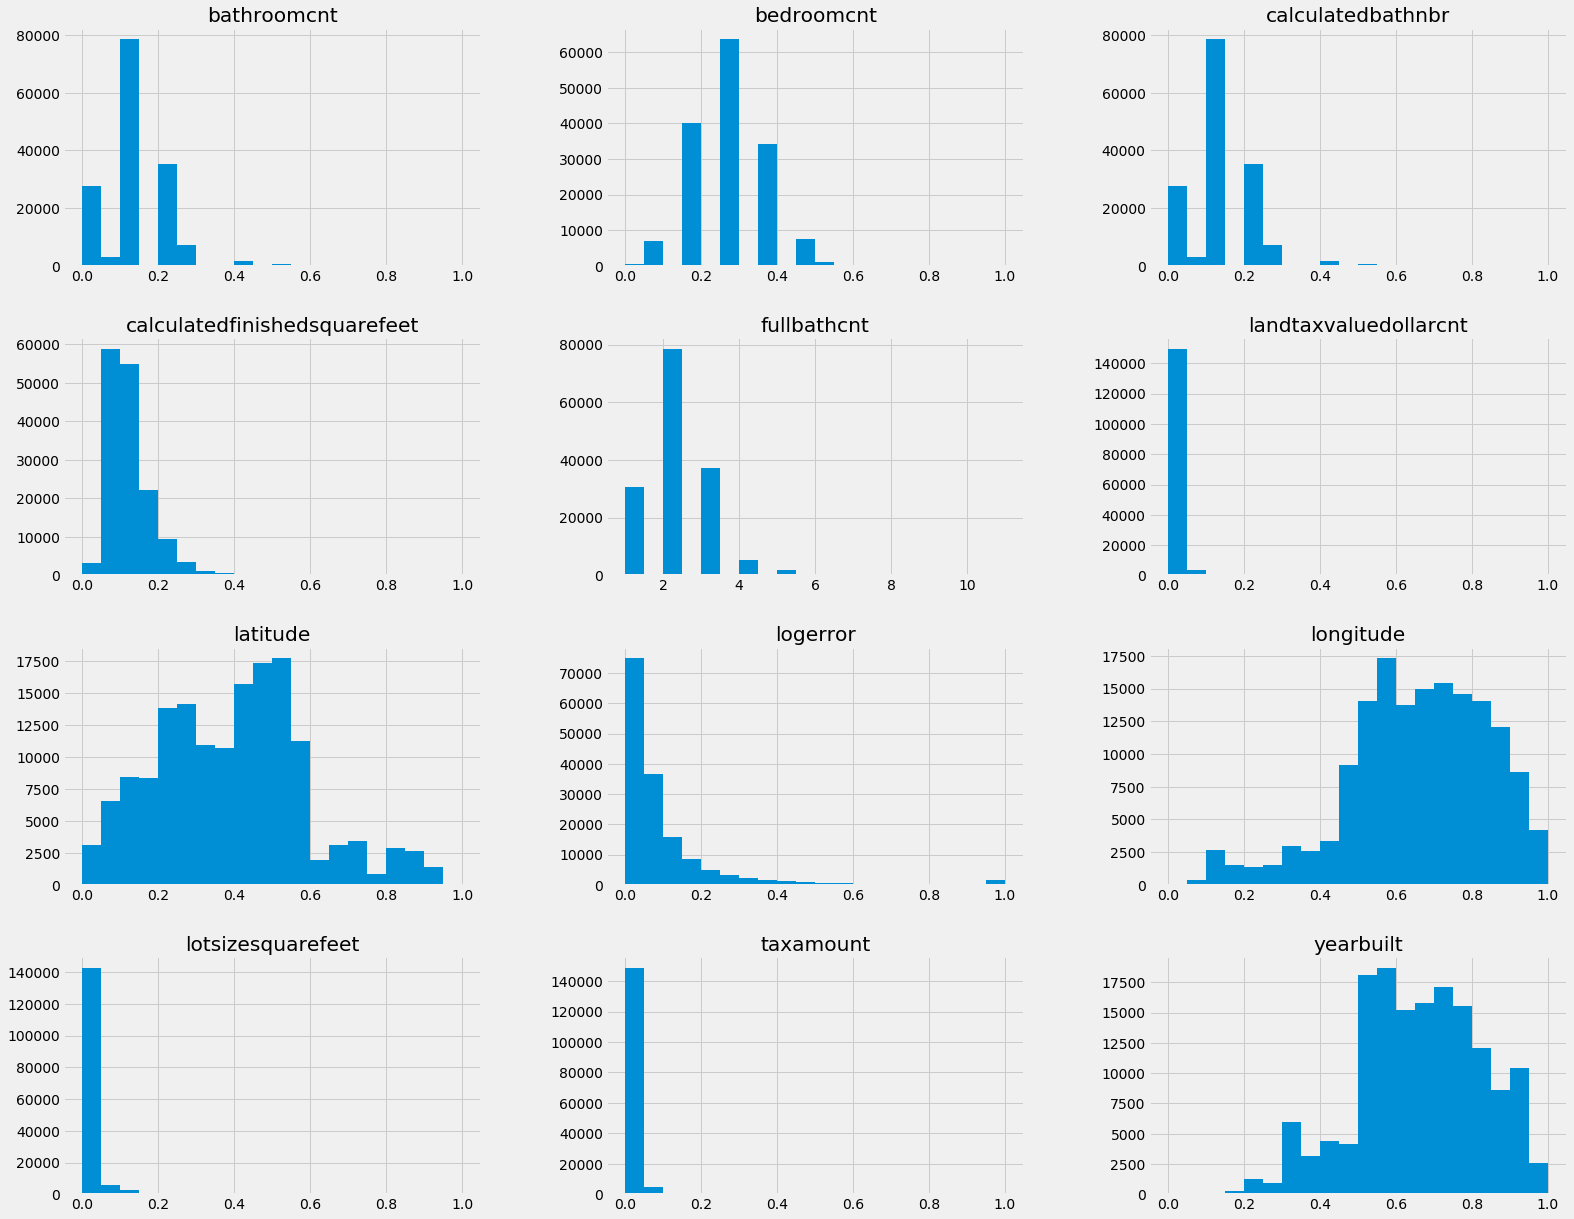

In [204]:
dd.plot_hist(df)

Let's now generate a pairplot to see how our variables interact with each other.

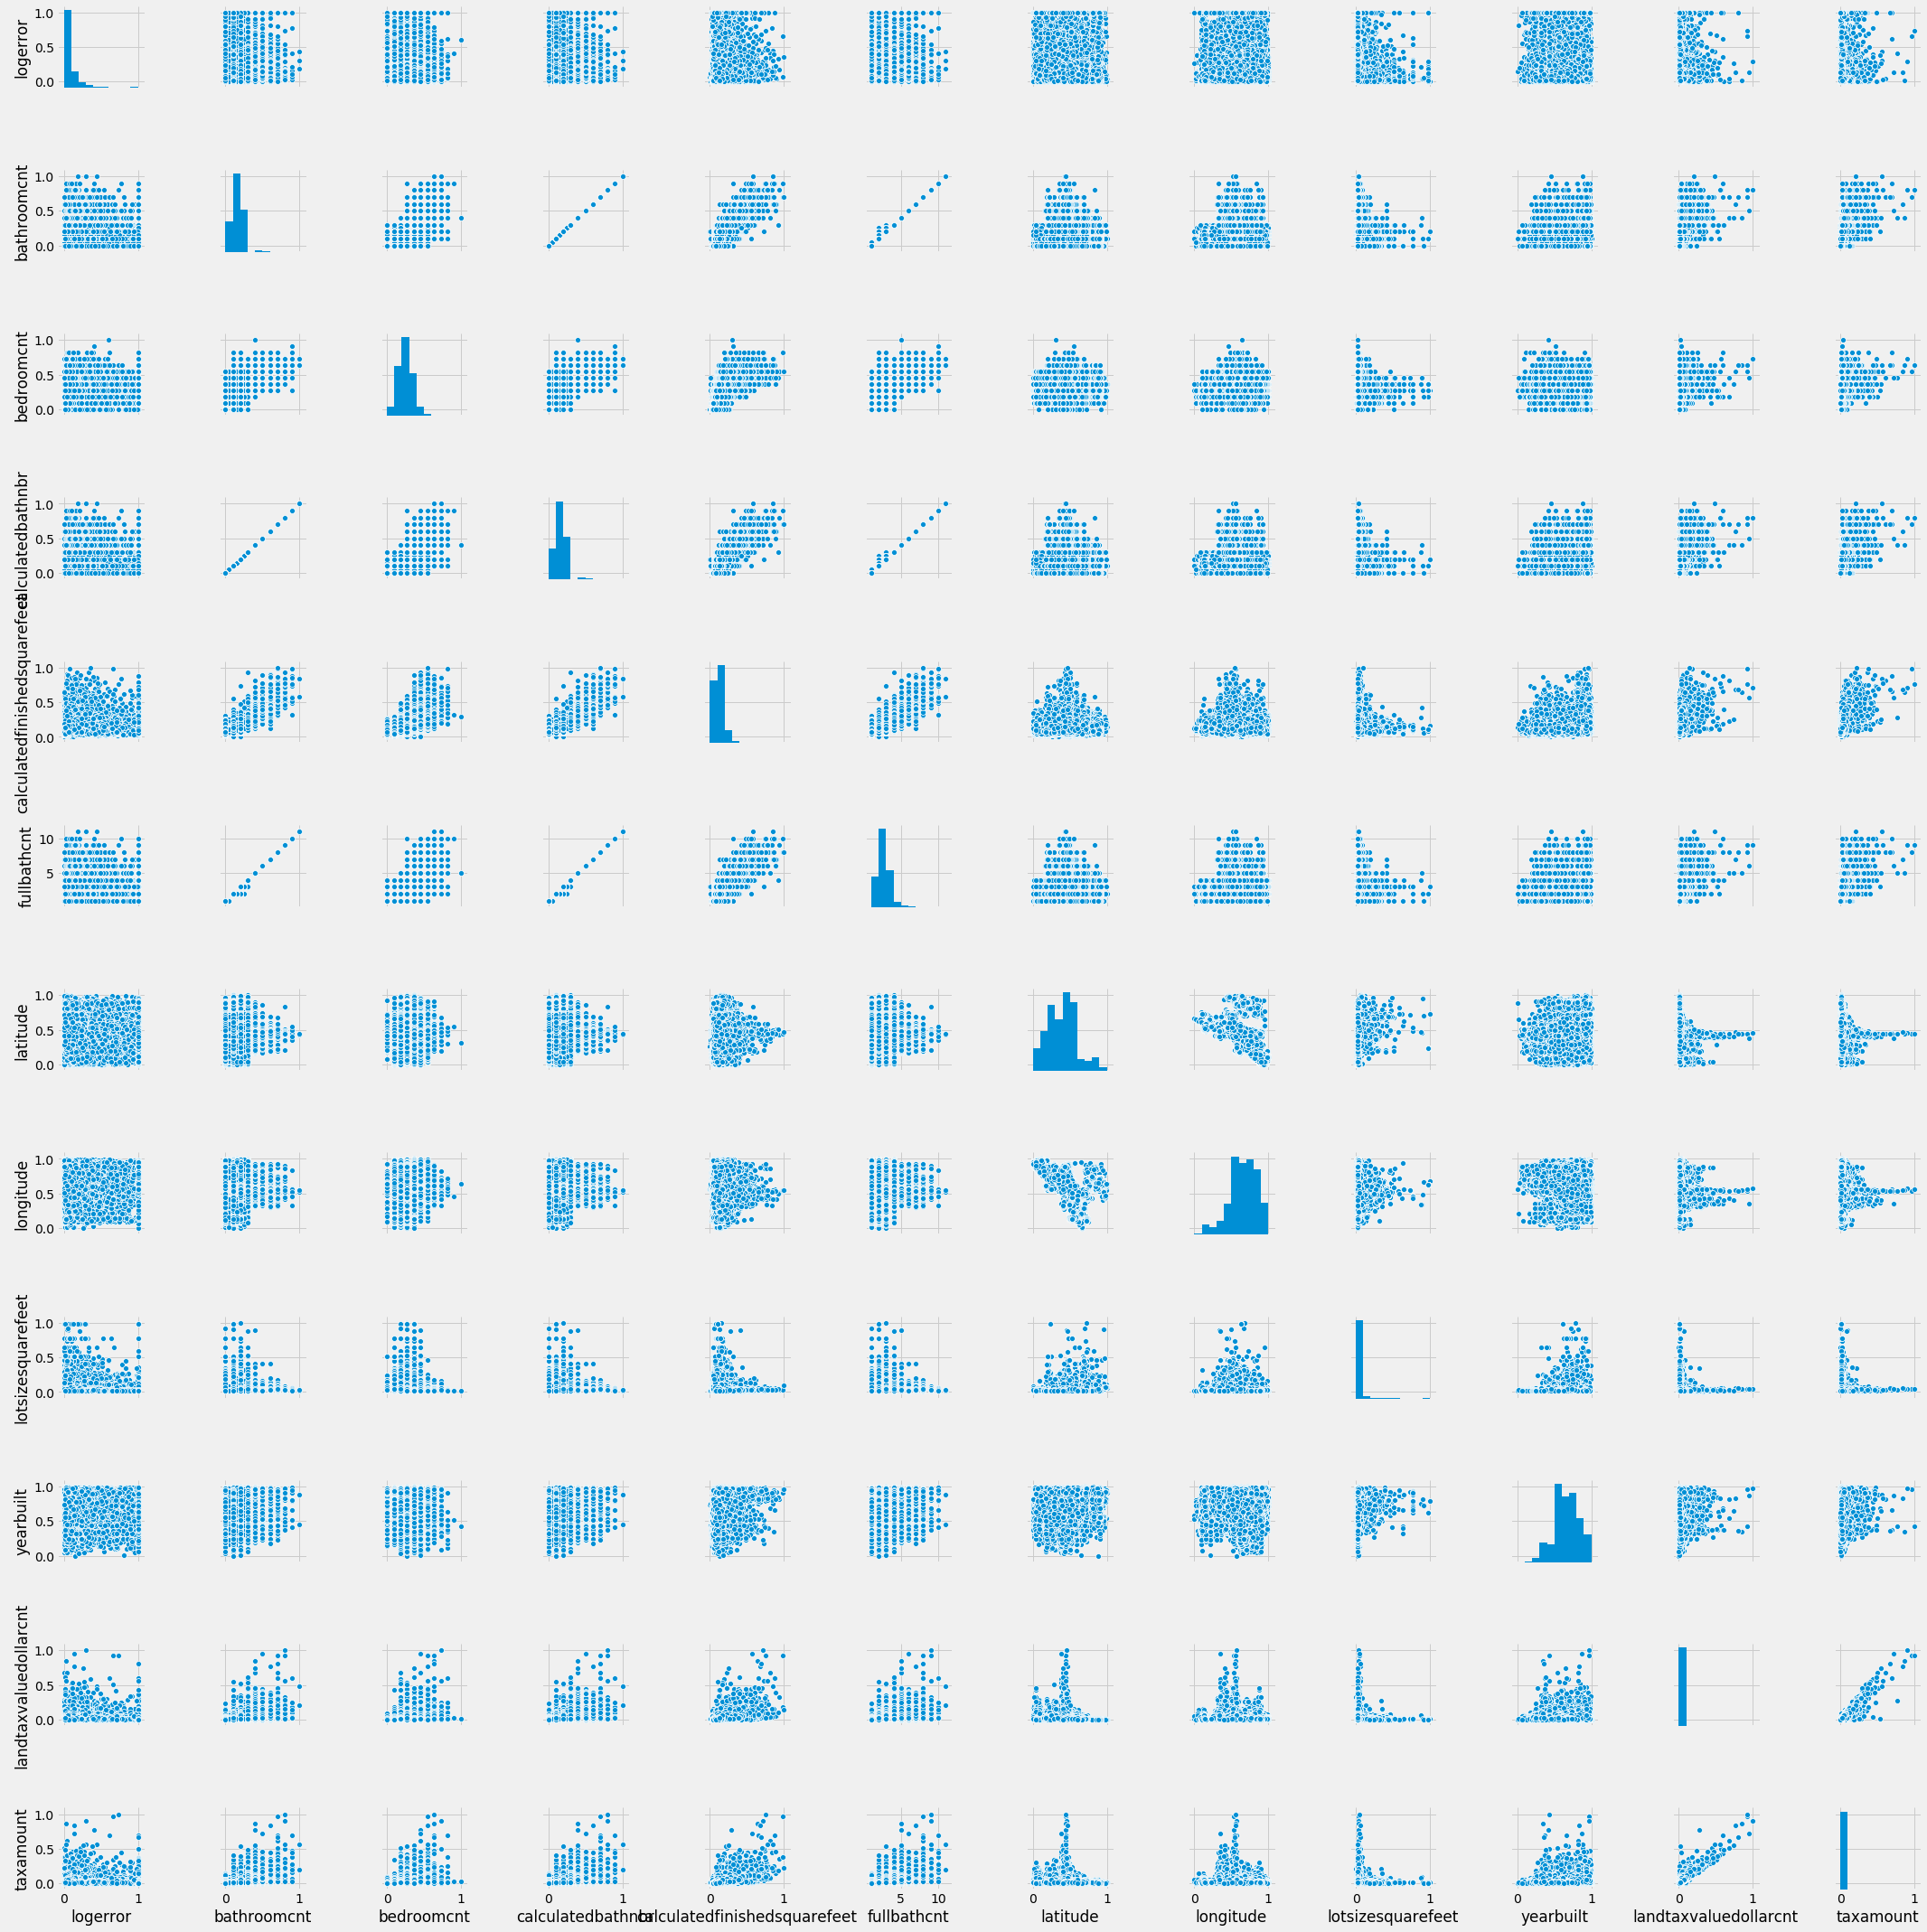

In [205]:
sns.pairplot(df, vars=num_cols)

And a heatmap to see the correlation of variables.

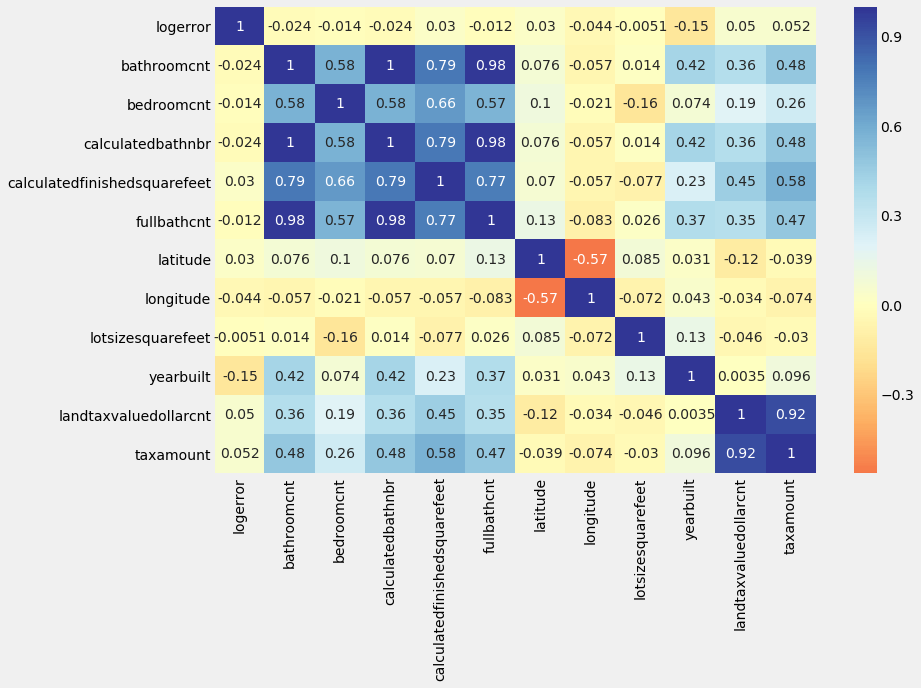

In [206]:
df_heat = df[num_cols]
dd.plot_heat(df_heat)

Let's remove redundant variables some more.

In [207]:
df = dd.remove_columns(df, cols_to_remove=['calculatedbathnbr',
                                           'fullbathcnt',
                                           'landtaxvaluedollarcnt'])
num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols

['logerror',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'yearbuilt',
 'taxamount']

Let's concentrate on single-unit dwellings...

In [208]:
df.propertylandusedesc.value_counts()

Single Family Residential                     108320
Condominium                                    41079
Planned Unit Development                        4132
Cluster Home                                     691
Mobile Home                                      126
Cooperative                                       57
Duplex (2 Units, Any Combination)                 50
Manufactured, Modular, Prefabricated Homes        37
Residential General                               29
Townhouse                                         17
Triplex (3 Units, Any Combination)                 6
Name: propertylandusedesc, dtype: int64

and narrow them down accordingly:

In [209]:
df = df.loc[(df['propertylandusedesc'] == 'Single Family Residential') |
                (df['propertylandusedesc'] == 'Condominium') |
                (df['propertylandusedesc'] == 'Residential General') |
                (df['propertylandusedesc'] == 'Townhouse')
               ]



In [210]:
df.propertylandusedesc.value_counts()

Single Family Residential    108320
Condominium                   41079
Residential General              29
Townhouse                        17
Name: propertylandusedesc, dtype: int64

In [211]:
dd.summarize_data(df)

HEAD
   logerror transactiondate  bathroomcnt  bedroomcnt buildingqualitytypeid  \
0  0.046062      2016-01-01         0.10    0.272727                   4.0   
1  0.285610      2016-01-01         0.25    0.363636                   7.0   
2  0.005910      2016-01-01         0.20    0.181818                   4.0   
3  0.036194      2016-01-02         0.10    0.181818                   4.0   
5  0.459316      2016-01-02         0.30    0.363636                   1.0   

   calculatedfinishedsquarefeet  latitude  longitude  lotsizesquarefeet  \
0                      0.123713  0.592205   0.513791           0.019867   
1                      0.166299  0.127467   0.936005           0.017900   
2                      0.162916  0.482496   0.677008           0.021838   
3                      0.061562  0.193954   0.607262           0.051922   
5                      0.225434  0.280619   0.558444           0.017427   

  regionidcounty regionidzip  yearbuilt  taxamount        propertylandusede

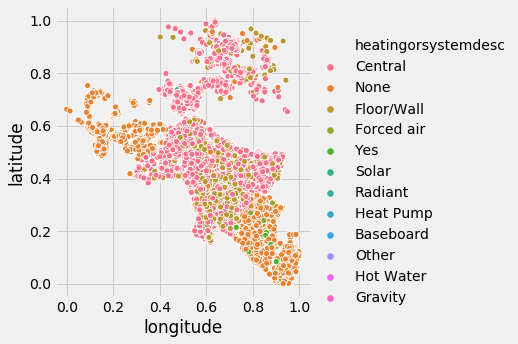

In [212]:
dd.plot_rel(df, 'longitude', 'latitude', 'heatingorsystemdesc')

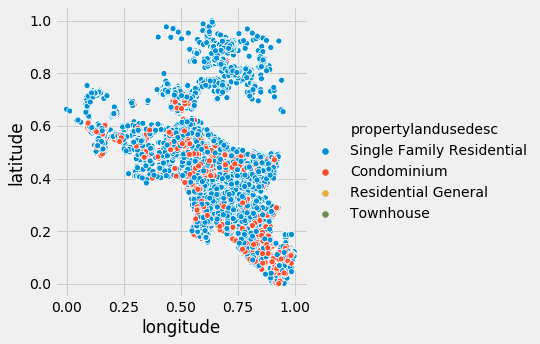

In [213]:
dd.plot_rel(df, 'longitude', 'latitude', 'propertylandusedesc')

In [214]:
num_cols

['logerror',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'yearbuilt',
 'taxamount']

In [215]:
df_xgb_x = df[num_cols].drop(columns=['logerror'])

In [216]:
fn = df_xgb_x.columns.values

/usr/local/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


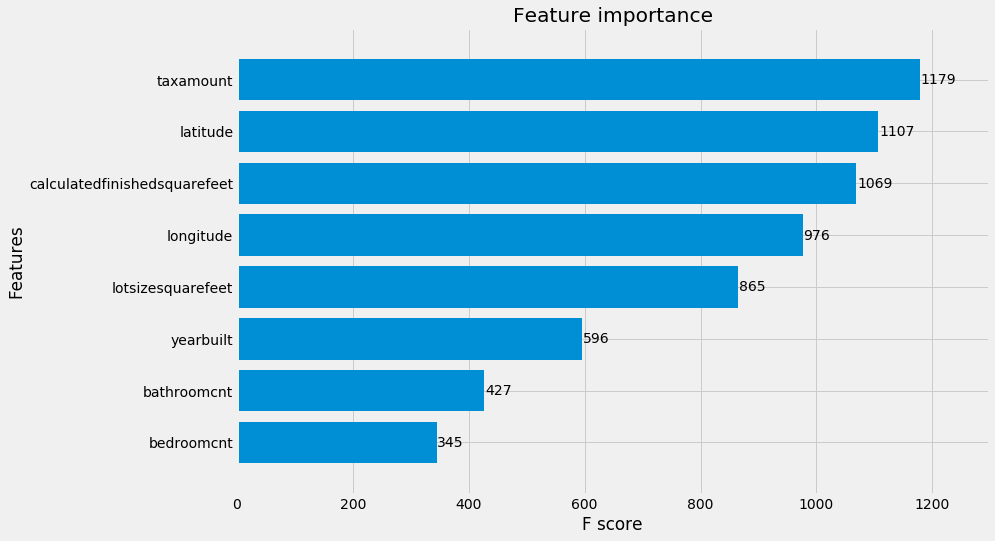

In [217]:
xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(df_xgb_x, df.logerror, feature_names=fn)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

## Clustering

### Cluster 1 - logerror

In [218]:
df_c1 = df[['logerror']]

   k          sse
0  1  3540.259710
1  2  1138.648072
2  3   514.578510
3  4   281.739544
4  5   176.713360
5  6   118.765296
6  7    86.515121
7  8    65.135886
8  9    50.717060


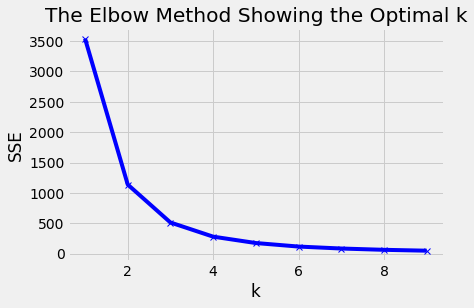

In [219]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_c1)

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method Showing the Optimal k')
plt.show()

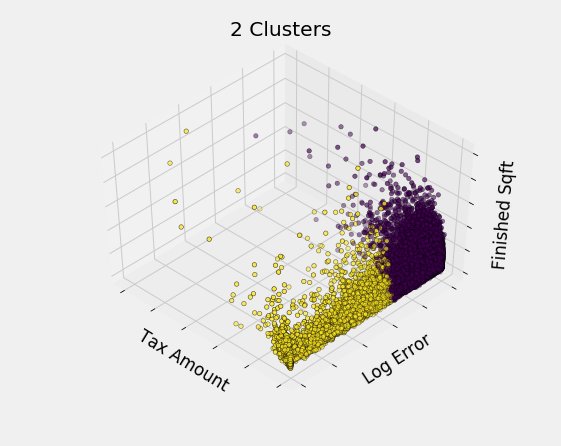

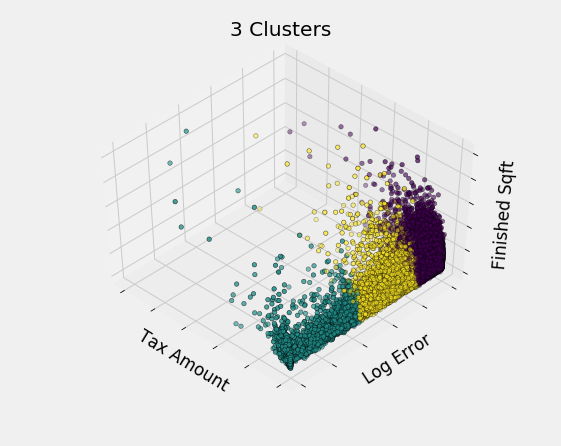

In [220]:
estimators = [('2 Clusters', KMeans(n_clusters=2)),
              ('3 Clusters', KMeans(n_clusters=3))]

for i, (title, kmeans) in enumerate(estimators):
    # fit the kmeans object
    kmeans.fit(df_c1)

    fig = plt.figure(i + 1, figsize=(8, 6))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    labels = kmeans.labels_

    ax.scatter(df.taxamount, 
               df.logerror,
               df.calculatedfinishedsquarefeet,
               c=labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Tax Amount')
    ax.set_ylabel('Log Error')
    ax.set_zlabel('Finished Sqft')
    ax.set_title(title)
    ax.dist = 12

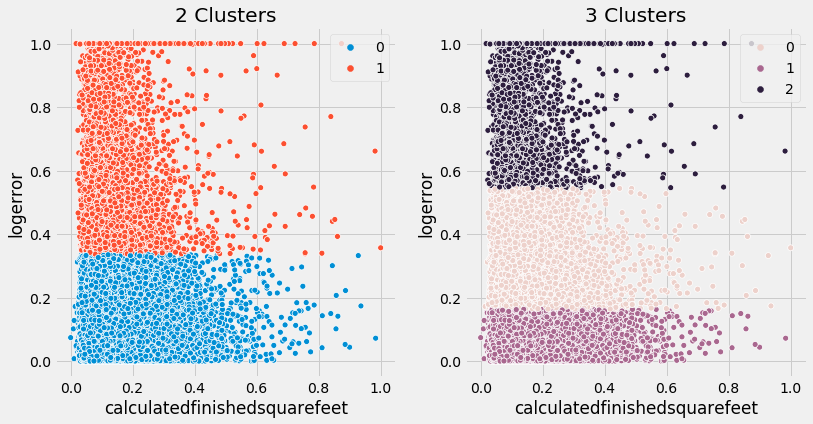

In [221]:
plt.subplots(nrows=1,ncols=2, figsize=(12,6))
for i, (title, kmeans) in enumerate(estimators):
    kmeans.fit(df_c1)
    labels = kmeans.labels_
    plot_number = i + 1 # i starts at 0, but plot numbers should start at 1
    plt.subplot(1, 2, plot_number)
    plt.title(title)
    sns.scatterplot(df.calculatedfinishedsquarefeet, df.logerror, hue=labels)

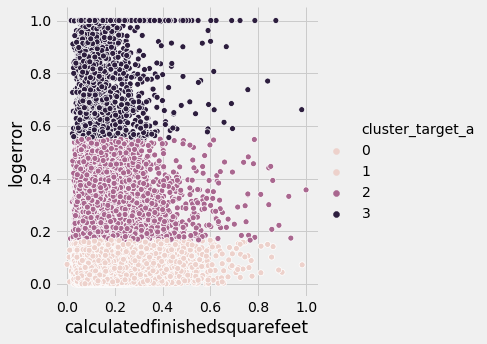

In [222]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_c1)
df['cluster_target_a'] = kmeans.predict(df_c1)
df.cluster_target_a = (df.cluster_target_a + 1)
sns.relplot(data=df, x='calculatedfinishedsquarefeet', y='logerror', hue='cluster_target_a')

In [223]:
df.cluster_target_a.value_counts()

1    126197
2     19171
3      4077
Name: cluster_target_a, dtype: int64

In [224]:
kmeans.cluster_centers_

array([[0.05164617],
       [0.27990422],
       [0.82110745]])

In [225]:
df.head()

logerror transactiondate  bathroomcnt  bedroomcnt buildingqualitytypeid  \
0  0.046062      2016-01-01         0.10    0.272727                   4.0   
1  0.285610      2016-01-01         0.25    0.363636                   7.0   
2  0.005910      2016-01-01         0.20    0.181818                   4.0   
3  0.036194      2016-01-02         0.10    0.181818                   4.0   
5  0.459316      2016-01-02         0.30    0.363636                   1.0   

   calculatedfinishedsquarefeet  latitude  longitude  lotsizesquarefeet  \
0                      0.123713  0.592205   0.513791           0.019867   
1                      0.166299  0.127467   0.936005           0.017900   
2                      0.162916  0.482496   0.677008           0.021838   
3                      0.061562  0.193954   0.607262           0.051922   
5                      0.225434  0.280619   0.558444           0.017427   

  regionidcounty regionidzip  yearbuilt  taxamount        propertylandusedesc  \
0         3101.0     96370.0   0.586957   0.020862  Single Family Residential   
1         1286.0     96962.0   0.985507   0.031477  Single Family Residential   
2         3101.0     96293.0   0.449275   0.035613  Single Family Residential   
3         3101.0     96222.0   0.789855   0.009409                Condominium   
5         3101.0     96109.0   0.753623   0.084204  Single Family Residential   

  heatingorsystemdesc  cluster_target_a  
0             Central                 1  
1                None                 2  
2             Central                 1  
3             Central                 1  
5             Central                 2

## Cluster 2 - calculatedfinishedsquarefeet

In [226]:
df_c2 = df[['calculatedfinishedsquarefeet']]

   k         sse
0  1  551.104361
1  2  223.911082
2  3  131.993148
3  4   83.522637
4  5   56.199595
5  6   41.456194
6  7   31.263874
7  8   24.479634
8  9   19.491901


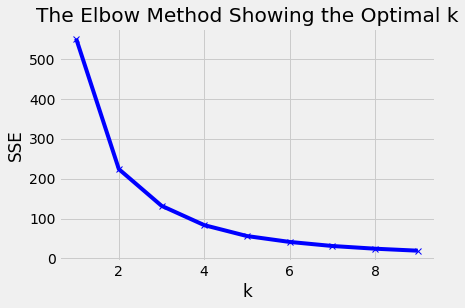

In [227]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_c2)

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method Showing the Optimal k')
plt.show()

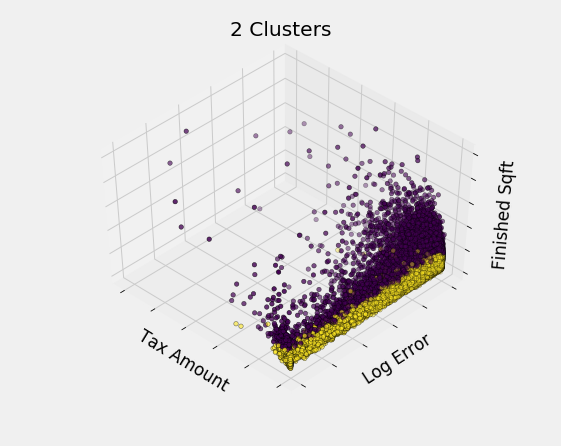

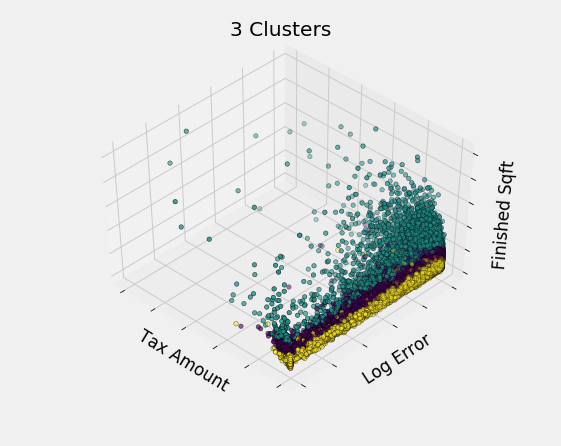

In [228]:
estimators = [('2 Clusters', KMeans(n_clusters=2)),
              ('3 Clusters', KMeans(n_clusters=3))]

for i, (title, kmeans) in enumerate(estimators):
    # fit the kmeans object
    kmeans.fit(df_c2)

    fig = plt.figure(i + 1, figsize=(8, 6))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    labels = kmeans.labels_

    ax.scatter(df.taxamount, 
               df.logerror,
               df.calculatedfinishedsquarefeet,
               c=labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Tax Amount')
    ax.set_ylabel('Log Error')
    ax.set_zlabel('Finished Sqft')
    ax.set_title(title)
    ax.dist = 12

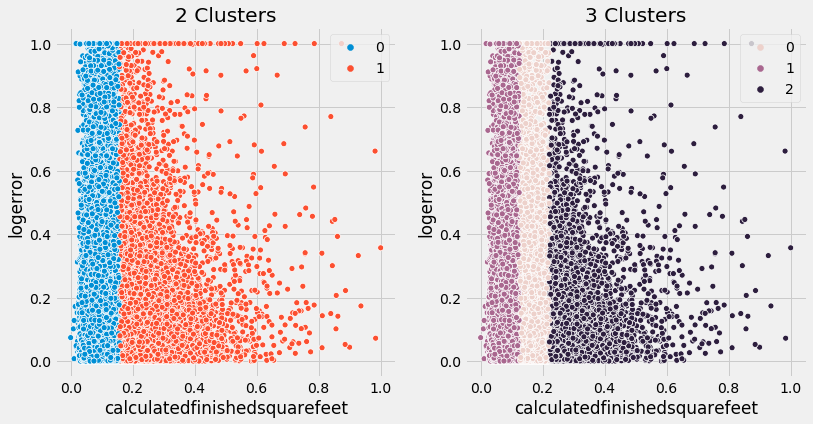

In [229]:
plt.subplots(nrows=1,ncols=2, figsize=(12,6))
for i, (title, kmeans) in enumerate(estimators):
    kmeans.fit(df_c2)
    labels = kmeans.labels_
    plot_number = i + 1 # i starts at 0, but plot numbers should start at 1
    plt.subplot(1, 2, plot_number)
    plt.title(title)
    sns.scatterplot(df.calculatedfinishedsquarefeet, df.logerror, hue=labels)

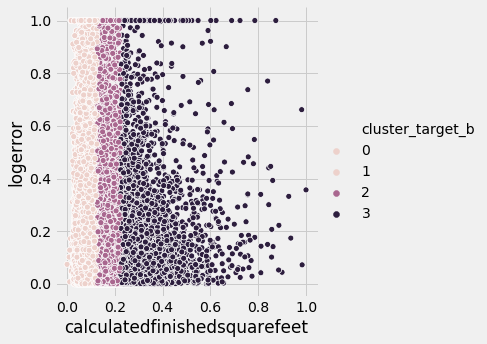

In [230]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_c2)
df['cluster_target_b'] = kmeans.predict(df_c2)
df.cluster_target_b = (df.cluster_target_b + 1)
sns.relplot(data=df, x='calculatedfinishedsquarefeet', y='logerror', hue='cluster_target_b')


In [231]:
kmeans.cluster_centers_

array([[0.09002796],
       [0.16112798],
       [0.28485403]])

In [232]:
df.head()

logerror transactiondate  bathroomcnt  bedroomcnt buildingqualitytypeid  \
0  0.046062      2016-01-01         0.10    0.272727                   4.0   
1  0.285610      2016-01-01         0.25    0.363636                   7.0   
2  0.005910      2016-01-01         0.20    0.181818                   4.0   
3  0.036194      2016-01-02         0.10    0.181818                   4.0   
5  0.459316      2016-01-02         0.30    0.363636                   1.0   

   calculatedfinishedsquarefeet  latitude  longitude  lotsizesquarefeet  \
0                      0.123713  0.592205   0.513791           0.019867   
1                      0.166299  0.127467   0.936005           0.017900   
2                      0.162916  0.482496   0.677008           0.021838   
3                      0.061562  0.193954   0.607262           0.051922   
5                      0.225434  0.280619   0.558444           0.017427   

  regionidcounty regionidzip  yearbuilt  taxamount        propertylandusedesc  \
0         3101.0     96370.0   0.586957   0.020862  Single Family Residential   
1         1286.0     96962.0   0.985507   0.031477  Single Family Residential   
2         3101.0     96293.0   0.449275   0.035613  Single Family Residential   
3         3101.0     96222.0   0.789855   0.009409                Condominium   
5         3101.0     96109.0   0.753623   0.084204  Single Family Residential   

  heatingorsystemdesc  cluster_target_a  cluster_target_b  
0             Central                 1                 1  
1                None                 2                 2  
2             Central                 1                 2  
3             Central                 1                 1  
5             Central                 2                 3

### Cluster 3 - lotsizesquarefeet

In [233]:
df_c3 = df[['lotsizesquarefeet']]

   k         sse
0  1  278.210834
1  2   98.726545
2  3   51.826285
3  4   30.568818
4  5   19.151820
5  6   12.538488
6  7    8.655721
7  8    6.340673
8  9    5.053252


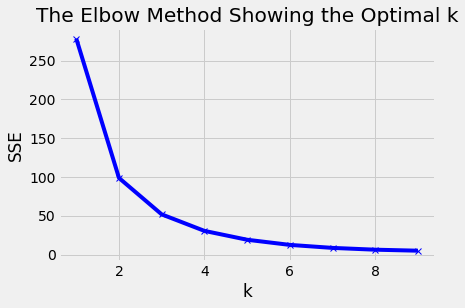

In [234]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_c3)

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method Showing the Optimal k')
plt.show()

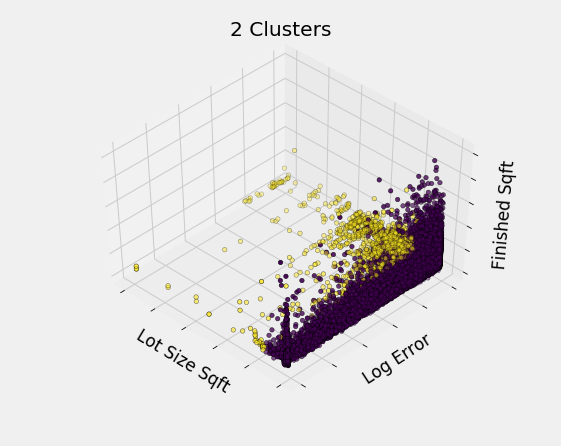

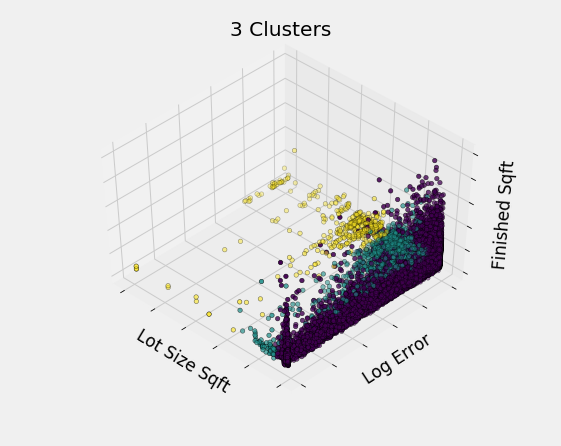

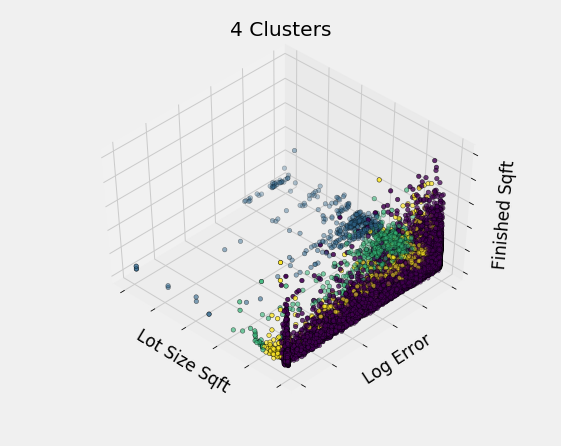

In [235]:
estimators = [('2 Clusters', KMeans(n_clusters=2)),
              ('3 Clusters', KMeans(n_clusters=3)),
              ('4 Clusters', KMeans(n_clusters=4))]

for i, (title, kmeans) in enumerate(estimators):
    # fit the kmeans object
    kmeans.fit(df_c3)

    fig = plt.figure(i + 1, figsize=(8, 6))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    labels = kmeans.labels_

    ax.scatter(df.lotsizesquarefeet, 
               df.logerror,
               df.calculatedfinishedsquarefeet,
               c=labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Lot Size Sqft')
    ax.set_ylabel('Log Error')
    ax.set_zlabel('Finished Sqft')
    ax.set_title(title)
    ax.dist = 12

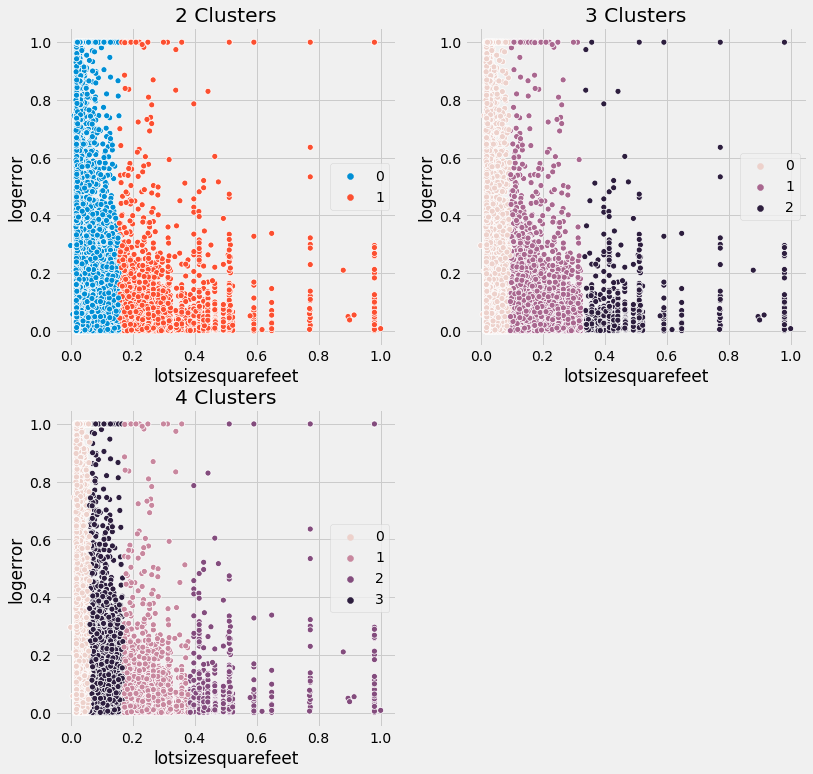

In [236]:
plt.subplots(nrows=1,ncols=2, figsize=(12,12))
for i, (title, kmeans) in enumerate(estimators):
    kmeans.fit(df_c3)
    labels = kmeans.labels_
    plot_number = i + 1 # i starts at 0, but plot numbers should start at 1
    plt.subplot(2, 2, plot_number)
    plt.title(title)
    sns.scatterplot(df.lotsizesquarefeet, df.logerror, hue=labels)

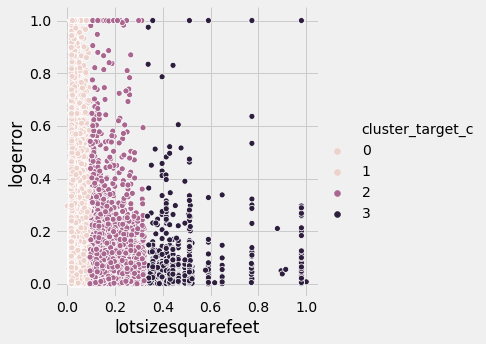

In [237]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_c3)
df['cluster_target_c'] = kmeans.predict(df_c3)
df.cluster_target_c = (df.cluster_target_c + 1)
sns.relplot(data=df, x='lotsizesquarefeet', y='logerror', hue='cluster_target_c')


In [238]:
kmeans.cluster_centers_

array([[0.02425134],
       [0.16547367],
       [0.50450305]])

In [239]:
df.head()

logerror transactiondate  bathroomcnt  bedroomcnt buildingqualitytypeid  \
0  0.046062      2016-01-01         0.10    0.272727                   4.0   
1  0.285610      2016-01-01         0.25    0.363636                   7.0   
2  0.005910      2016-01-01         0.20    0.181818                   4.0   
3  0.036194      2016-01-02         0.10    0.181818                   4.0   
5  0.459316      2016-01-02         0.30    0.363636                   1.0   

   calculatedfinishedsquarefeet  latitude  longitude  lotsizesquarefeet  \
0                      0.123713  0.592205   0.513791           0.019867   
1                      0.166299  0.127467   0.936005           0.017900   
2                      0.162916  0.482496   0.677008           0.021838   
3                      0.061562  0.193954   0.607262           0.051922   
5                      0.225434  0.280619   0.558444           0.017427   

  regionidcounty regionidzip  yearbuilt  taxamount        propertylandusedesc  \
0         3101.0     96370.0   0.586957   0.020862  Single Family Residential   
1         1286.0     96962.0   0.985507   0.031477  Single Family Residential   
2         3101.0     96293.0   0.449275   0.035613  Single Family Residential   
3         3101.0     96222.0   0.789855   0.009409                Condominium   
5         3101.0     96109.0   0.753623   0.084204  Single Family Residential   

  heatingorsystemdesc  cluster_target_a  cluster_target_b  cluster_target_c  
0             Central                 1                 1                 1  
1                None                 2                 2                 1  
2             Central                 1                 2                 1  
3             Central                 1                 1                 1  
5             Central                 2                 3                 1

### Test the Significance of Clusters

In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149445 entries, 0 to 167887
Data columns (total 18 columns):
logerror                        149445 non-null float64
transactiondate                 149445 non-null object
bathroomcnt                     149445 non-null float64
bedroomcnt                      149445 non-null float64
buildingqualitytypeid           149445 non-null object
calculatedfinishedsquarefeet    149445 non-null float64
latitude                        149445 non-null float64
longitude                       149445 non-null float64
lotsizesquarefeet               149445 non-null float64
regionidcounty                  149445 non-null object
regionidzip                     149445 non-null object
yearbuilt                       149445 non-null float64
taxamount                       149445 non-null float64
propertylandusedesc             149445 non-null object
heatingorsystemdesc             149445 non-null object
cluster_target_a                149445 non-null int64
c

In [241]:
ct_j = df[df['cluster_target_b'] == 1]
ct_k = df[df['cluster_target_b'] == 2]

stat, p = stats.ttest_ind(ct_j['logerror'], ct_k['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

T-stat: 7.945629643783314
p-value: 1.9463161375107856e-15


In [242]:
ct_j = df[df['cluster_target_b'] == 2]
ct_k = df[df['cluster_target_b'] == 3]

stat, p = stats.ttest_ind(ct_j['logerror'], ct_k['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

T-stat: -22.2482098658456
p-value: 3.523813210649526e-109


In [243]:
ct_j = df[df['cluster_target_c'] == 1]
ct_k = df[df['cluster_target_c'] == 2]

stat, p = stats.ttest_ind(ct_j['logerror'], ct_k['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

T-stat: 4.011591610136517
p-value: 6.034019348755757e-05


In [244]:
ct_j = df[df['cluster_target_c'] == 2]
ct_k = df[df['cluster_target_c'] == 3]

stat, p = stats.ttest_ind(ct_j['logerror'], ct_k['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

T-stat: -2.645190924947387
p-value: 0.008187374473391226


In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149445 entries, 0 to 167887
Data columns (total 18 columns):
logerror                        149445 non-null float64
transactiondate                 149445 non-null object
bathroomcnt                     149445 non-null float64
bedroomcnt                      149445 non-null float64
buildingqualitytypeid           149445 non-null object
calculatedfinishedsquarefeet    149445 non-null float64
latitude                        149445 non-null float64
longitude                       149445 non-null float64
lotsizesquarefeet               149445 non-null float64
regionidcounty                  149445 non-null object
regionidzip                     149445 non-null object
yearbuilt                       149445 non-null float64
taxamount                       149445 non-null float64
propertylandusedesc             149445 non-null object
heatingorsystemdesc             149445 non-null object
cluster_target_a                149445 non-null int64
c

In [246]:
df_normal.sample(100)

logerror transactiondate  bathroomcnt  bedroomcnt  \
45876   0.141500      2016-06-15          4.0         4.0   
117020  0.006375      2017-04-14          2.0         3.0   
4372    0.072600      2016-01-22          1.0         2.0   
90664   0.088469      2017-01-03          2.0         4.0   
72535   0.006000      2016-09-01          3.0         4.0   
111928  0.057048      2017-03-30          2.0         3.0   
108891  0.001701      2017-03-20          2.0         2.0   
18119   0.030500      2016-03-21          2.5         3.0   
96275   0.023939      2017-01-27          2.0         3.0   
59745   0.067700      2016-07-26          2.0         4.0   
20532   0.085600      2016-03-30          2.0         3.0   
142380  0.117898      2017-06-29          3.0         4.0   
117883  0.001655      2017-04-18          2.0         4.0   
90083   0.102600      2016-12-29          3.0         5.0   
104720  0.066159      2017-03-03          3.0         4.0   
9676    0.020200      2016-02-17          1.5         3.0   
128528  0.011529      2017-05-19          2.5         3.0   
84794   0.028600      2016-10-13          2.0         3.0   
64861   0.119600      2016-08-10          3.0         4.0   
167337  0.083045      2017-09-15          2.0         3.0   
117350  0.095536      2017-04-17          1.5         1.0   
15782   0.006000      2016-03-11          2.0         3.0   
81478   0.250000      2016-09-30          1.0         2.0   
163905  0.010563      2017-09-05          3.0         4.0   
51458   0.105400      2016-06-30          2.0         2.0   
19667   0.207800      2016-03-25          2.0         4.0   
91639   0.003233      2017-01-06          2.0         3.0   
89808   0.014900      2016-12-22          2.0         4.0   
28948   0.007000      2016-04-26          3.0         4.0   
158623  0.022968      2017-08-18          2.0         3.0   
...          ...             ...          ...         ...   
98395   0.015659      2017-02-06          3.0         2.0   
50669   0.019800      2016-06-29          3.0         4.0   
95176   0.149415      2017-01-23          6.0         6.0   
146180  0.065329      2017-07-11          2.0         4.0   
159940  0.004897      2017-08-24          2.0         3.0   
26808   0.035400      2016-04-19          2.0         4.0   
30416   0.042900      2016-04-29          2.0         3.0   
110688  0.011951      2017-03-27          2.0         3.0   
86757   0.006000      2016-11-01          2.0         5.0   
54515   0.031500      2016-07-11          2.0         3.0   
159262  0.227417      2017-08-22          1.0         2.0   
2449    0.034600      2016-01-14          1.0         3.0   
124538  0.077827      2017-05-09          3.0         3.0   
20152   0.042100      2016-03-29          3.0         3.0   
57905   0.009000      2016-07-21          2.0         2.0   
56155   0.056400      2016-07-15          2.0         2.0   
119387  0.097772      2017-04-24          2.0         3.0   
71462   0.216700      2016-08-30          1.0         1.0   
154830  0.034552      2017-08-08          3.0         3.0   
161964  0.063835      2017-08-30          2.0         4.0   
27205   0.002000      2016-04-20          2.0         4.0   
64159   0.104300      2016-08-08          1.0         2.0   
73056   0.046900      2016-09-02          3.0         3.0   
30731   0.014900      2016-04-29          2.0         3.0   
27722   0.012100      2016-04-21          2.0         2.0   
164623  0.011659      2017-09-07          2.0         2.0   
82213   0.028600      2016-10-04          1.0         2.0   
122562  0.000922      2017-05-02          3.0         4.0   
12257   0.008000      2016-02-26          2.0         3.0   
14692   0.099800      2016-03-08          1.0         1.0   

       buildingqualitytypeid  calculatedbathnbr  calculatedfinishedsquarefeet  \
45876                    1.0                4.0                        3147.0   
117020                   7.0                2.0                

In [247]:
df_normal.bathroomcnt.value_counts()

2.0     64556
3.0     35308
1.0     27685
2.5     13972
4.0      5397
1.5      3003
3.5      1952
5.0      1712
6.0       625
7.0       191
8.0       101
9.0        28
10.0       11
11.0        3
Name: bathroomcnt, dtype: int64

In [248]:
data_bath_3 = df_normal[df_normal['bathroomcnt'] <= 3.0]
data_bath_4 = df_normal[df_normal['bathroomcnt'] >= 4.0]

stat, p = stats.ttest_ind(data_bath_3['logerror'], data_bath_3['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

T-stat: 0.0
p-value: 1.0


In [249]:
data_bed_3 = df_normal[df_normal['bedroomcnt'] == 3.0]
data_bed_5 = df_normal[df_normal['bedroomcnt'] >= 5.0]

stat, p = stats.ttest_ind(data_bed_3['logerror'], data_bed_5['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

# if p-value is < 0.05, you can reject the null hypothesis

T-stat: -10.165509458956173
p-value: 2.934550723498122e-24


# Modeling

## Feature Engineering

### Remove variables that are not needed, wanted, or redundant.

In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149445 entries, 0 to 167887
Data columns (total 18 columns):
logerror                        149445 non-null float64
transactiondate                 149445 non-null object
bathroomcnt                     149445 non-null float64
bedroomcnt                      149445 non-null float64
buildingqualitytypeid           149445 non-null object
calculatedfinishedsquarefeet    149445 non-null float64
latitude                        149445 non-null float64
longitude                       149445 non-null float64
lotsizesquarefeet               149445 non-null float64
regionidcounty                  149445 non-null object
regionidzip                     149445 non-null object
yearbuilt                       149445 non-null float64
taxamount                       149445 non-null float64
propertylandusedesc             149445 non-null object
heatingorsystemdesc             149445 non-null object
cluster_target_a                149445 non-null int64
c

In [251]:
df = dd.remove_columns(df, cols_to_remove=['transactiondate'])

### Add any features you think may be useful.

In [252]:
df_bbroom = df
df_bbroom['bbroom'] = df.bathroomcnt + df.bedroomcnt
df_bbroom.drop(columns=['bathroomcnt', 'bedroomcnt'])

logerror buildingqualitytypeid  calculatedfinishedsquarefeet  \
0       0.046062                   4.0                      0.123713   
1       0.285610                   7.0                      0.166299   
2       0.005910                   4.0                      0.162916   
3       0.036194                   4.0                      0.061562   
5       0.459316                   1.0                      0.225434   
6       0.073964                   7.0                      0.095249   
7       0.277783                   7.0                      0.129523   
8       0.004209                   7.0                      0.058400   
9       0.142527                   7.0                      0.092527   
10      0.649865                   7.0                      0.104075   
11      0.026496                   1.0                      0.226390   
12      0.057631                   7.0                      0.109003   
13      0.137934                   7.0                      0.091718   
14      0.075665                   7.0                      0.100397   
15      0.002508                   7.0                      0.095616   
17      0.070391                   7.0                      0.043763   
18      0.002508                   7.0                      0.097014   
19      0.016118                   4.0                      0.126876   
20      0.064947                   7.0                      0.061636   
21      0.036194                   7.0                      0.108414   
22      0.024455                   7.0                      0.105031   
23      0.194928                   4.0                      0.275596   
24      0.287651                   7.0                      0.089070   
25      0.073964                   7.0                      0.137761   
26      0.126195                   4.0                      0.095616   
28      0.000806                   4.0                      0.076714   
29      0.089956                   4.0                      0.097602   
30      0.066818                   7.0                      0.083995   
31      0.049124                   1.0                      0.104442   
32      0.034493                   7.0                      0.119815   
...          ...                   ...                           ...   
167855  0.057550                   7.0                      0.157326   
167856  0.033848                   8.0                      0.136584   
167858  0.160306                   5.0                      0.070462   
167859  0.109292                   4.0                      0.085172   
167860  0.078650                   7.0                      0.089070   
167861  0.030507                   4.0                      0.061047   
167862  0.002742                   6.0                      0.130332   
167863  1.000000                   4.0                      0.116064   
167864  0.004986                   4.0                      0.060165   
167865  0.060467                   8.0                      0.078553   
167866  0.394180                   9.0                      0.260150   
167868  0.116222                   8.0                      0.092380   
167869  0.000000                   4.0                      0.062813   
167870  0.079862                   8.0                      0.159164   
167871  0.000380                   4.0                      0.075096   
167873  1.000000                   6.0                      0.094072   
167874  0.105274                   6.0                      0.108120   
167875  0.021679                   5.0                      0.045749   
167876  0.088646                   8.0                      0.063695   
167877  0.238790                   4.0                      0.066931   
167878  0.542525                   8.0                      0.151956   
167879  0.047989                  10.0                      0.161665   
167880  0.127496                   8.0                      0.092601   
167881  0.137247                   6.0          

In [253]:
df.head()

logerror  bathroomcnt  bedroomcnt buildingqualitytypeid  \
0  0.046062         0.10    0.272727                   4.0   
1  0.285610         0.25    0.363636                   7.0   
2  0.005910         0.20    0.181818                   4.0   
3  0.036194         0.10    0.181818                   4.0   
5  0.459316         0.30    0.363636                   1.0   

   calculatedfinishedsquarefeet  latitude  longitude  lotsizesquarefeet  \
0                      0.123713  0.592205   0.513791           0.019867   
1                      0.166299  0.127467   0.936005           0.017900   
2                      0.162916  0.482496   0.677008           0.021838   
3                      0.061562  0.193954   0.607262           0.051922   
5                      0.225434  0.280619   0.558444           0.017427   

  regionidcounty regionidzip  yearbuilt  taxamount        propertylandusedesc  \
0         3101.0     96370.0   0.586957   0.020862  Single Family Residential   
1         1286.0     96962.0   0.985507   0.031477  Single Family Residential   
2         3101.0     96293.0   0.449275   0.035613  Single Family Residential   
3         3101.0     96222.0   0.789855   0.009409                Condominium   
5         3101.0     96109.0   0.753623   0.084204  Single Family Residential   

  heatingorsystemdesc  cluster_target_a  cluster_target_b  cluster_target_c  \
0             Central                 1                 1                 1   
1                None                 2                 2                 1   
2             Central                 1                 2                 1   
3             Central                 1                 1                 1   
5             Central                 2                 3                 1   

     bbroom  
0  0.372727  
1  0.613636  
2  0.381818  
3  0.281818  
5  0.663636

In [254]:
df.regionidzip = df.regionidzip.astype(float)

In [255]:
# Copy of the dataframe before taking the absolute value of log errors.
df_nabs = df.copy()

In [256]:
# Take the absolute value of log errors
df.logerror = df.logerror.abs()
df.logerror.sample(10)

134193    0.154353
137391    0.011822
139842    0.216832
29933     0.086383
166007    0.044814
151696    0.035581
58921     0.000806
91895     0.006116
33613     0.083661
75944     0.022753
Name: logerror, dtype: float64

### Train and Test Split

In [257]:
# train_test_split
X = df.drop(['logerror'], axis=1)

print(X.head())

y = df[['logerror']]
print(y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=493)

train = pd.concat([X_train, y_train], axis=1)

print()
print("Train columns:  %s" % list(train.columns))
print("Train dimensions (rows, columns):", train.shape)
print()

test = pd.concat([X_test, y_test], axis=1)

print("Test columns:  %s" % list(test.columns))
print("Test dimensions (rows, columns):", test.shape)
print()

X.sample(10)

   bathroomcnt  bedroomcnt buildingqualitytypeid  \
0         0.10    0.272727                   4.0   
1         0.25    0.363636                   7.0   
2         0.20    0.181818                   4.0   
3         0.10    0.181818                   4.0   
5         0.30    0.363636                   1.0   

   calculatedfinishedsquarefeet  latitude  longitude  lotsizesquarefeet  \
0                      0.123713  0.592205   0.513791           0.019867   
1                      0.166299  0.127467   0.936005           0.017900   
2                      0.162916  0.482496   0.677008           0.021838   
3                      0.061562  0.193954   0.607262           0.051922   
5                      0.225434  0.280619   0.558444           0.017427   

  regionidcounty  regionidzip  yearbuilt  taxamount  \
0         3101.0      96370.0   0.586957   0.020862   
1         1286.0      96962.0   0.985507   0.031477   
2         3101.0      96293.0   0.449275   0.035613   
3         3101.0

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


bathroomcnt  bedroomcnt buildingqualitytypeid  \
138416         0.10    0.454545                   7.0   
74412          0.15    0.272727                   7.0   
146671         0.10    0.363636                   6.0   
71150          0.20    0.272727                   4.0   
76663          0.10    0.181818                   4.0   
60572          0.20    0.454545                   7.0   
16524          0.10    0.272727                   4.0   
14016          0.00    0.000000                   4.0   
111210         0.20    0.272727                   7.0   
106110         0.10    0.272727                   7.0   

        calculatedfinishedsquarefeet  latitude  longitude  lotsizesquarefeet  \
138416                      0.117976  0.177004   0.818579           0.019255   
74412                       0.096058  0.211053   0.800383           0.031579   
146671                      0.104295  0.567910   0.473148           0.019857   
71150                       0.105104  0.493149   0.708428           0.020280   
76663                       0.075610  0.691777   0.480751           0.285245   
60572                       0.200206  0.307732   0.888051           0.022130   
16524                       0.146219  0.907686   0.685668           0.020760   
14016                       0.033245  0.446164   0.574983           0.076847   
111210                      0.148647  0.302559   0.806996           0.017496   
106110                      0.123051  0.534352   0.148606           0.019581   

       regionidcounty  regionidzip  yearbuilt  taxamount  \
138416         1286.0      97004.0   0.594203   0.012321   
74412          1286.0      97047.0   0.731884   0.011465   
146671         3101.0      96346.0   0.572464   0.003784   
71150          3101.0      96294.0   0.927536   0.020393   
76663          3101.0      96378.0   0.789855   0.007729   
60572          1286.0      97078.0   0.760870   0.039544   
16524          3101.0      97317.0   0.724638   0.007644   
14016          3101.0      96050.0   0.688406   0.007091   
111210         1286.0      97043.0   0.717391   0.008488   
106110         2061.0      97101.0   0.536232   0.040732   

              propertylandusedesc heatingorsystemdesc  cluster_target_a  \
138416  Single Family Residential          Forced air                 1   
74412                 Condominium                None                 1   
146671  Single Family Residential             Central                 1   
71150                 Condominium             Central                 1   
76663                 Condominium             Central                 1   
60572   Single Family Residential                None                 1   
16524   Single Family Residential             Central                 1   
14016                 Condominium             Central                 1   
111210  Single Family Residential                None                 1   
106110  Single Family Residential                None                 1   

        cluster_target_b  cluster_target_c    bbroom  
138416                 1                 1  0.554545  
74412                  1                 1  0.422727  
146671                 1                 1  0.463636  
71150                  1                 1  0.472727  
76663                  1                 2  0.281818  
60572                  2                 1  0.654545  
16524                  2                 1  0.372727  
14016                  1                 1  0.000000  
111210                 2                 1  0.472727  
106110                 1                 1  0.372727

In [258]:
dd.validate_tts(X_train, y_train, X_test, y_test, train, test)

X & y train rows ARE equal
X & y test rows ARE equal
Number of columns in train & test ARE equal
Train Split: 0.80
Test Split: 0.20


## Model Selection

In [259]:
lm1, r2_lm1 = dd.model_linreg(X_train, y_train, features=['calculatedfinishedsquarefeet'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.09146978]
[[0.08176844]]

Univariate - log error = b + m1 * square feet
    y-intercept  (b): 0.09
    coefficient (m1): 0.08
lm0
  mse: 0.0237
  0.10% of the variance in the log error can be explained by the number of square feet.


In [260]:
lm2, r2_lm2 = dd.model_linreg(X_train, y_train, features=['taxamount'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.09456486]
[[0.40082453]]

Univariate - log error = b + m1 * square feet
    y-intercept  (b): 0.09
    coefficient (m1): 0.40
lm0
  mse: 0.0236
  0.28% of the variance in the log error can be explained by the number of square feet.


In [261]:
lm3, r2_lm3 = dd.model_linreg(X_train, y_train, features=['calculatedfinishedsquarefeet', 'taxamount', 'yearbuilt'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.18331952]
[[ 0.11398642  0.32600629 -0.15492373]]

Univariate - log error = b + m1 * square feet
    y-intercept  (b): 0.18
    coefficient (m1): 0.11
lm0
  mse: 0.023
  2.98% of the variance in the log error can be explained by the number of square feet.


In [262]:
lm4, r2_lm4 = dd.model_linreg(X_train, y_train, features=['calculatedfinishedsquarefeet', 'taxamount', 'latitude', 'longitude', 'lotsizesquarefeet'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.10769357]
[[-0.00155733  0.38986762  0.01384214 -0.02617796 -0.02600061]]

Univariate - log error = b + m1 * square feet
    y-intercept  (b): 0.11
    coefficient (m1): -0.00
lm0
  mse: 0.0236
  0.47% of the variance in the log error can be explained by the number of square feet.


In [264]:
lm5, r2_lm5 = dd.model_linreg(X_train, y_train, features=['cluster_target_a', 'cluster_target_b', 'cluster_target_c'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[-0.26010764]
[[0.30401738 0.00042304 0.00166155]]

Univariate - log error = b + m1 * square feet
    y-intercept  (b): -0.26
    coefficient (m1): 0.30
lm0
  mse: 0.00485
  79.51% of the variance in the log error can be explained by the number of square feet.


In [265]:
lm6, r2_lm6 = dd.model_linreg(X_train, y_train, features=['cluster_target_a', 'cluster_target_b'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[-0.25830619]
[[0.30401164 0.00037769]]

Univariate - log error = b + m1 * square feet
    y-intercept  (b): -0.26
    coefficient (m1): 0.30
lm0
  mse: 0.00485
  79.51% of the variance in the log error can be explained by the number of square feet.


In [267]:
lm7, r2_lm7 = dd.model_linreg(X_train, y_train, features=['cluster_target_c'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.10581501]
[[-0.00401461]]

Univariate - log error = b + m1 * square feet
    y-intercept  (b): 0.11
    coefficient (m1): -0.00
lm0
  mse: 0.0237
  0.00% of the variance in the log error can be explained by the number of square feet.


In [279]:
# Make predictions using the testing set
y_pred_lm5 = lm5.predict(X_test[['cluster_target_a', 'cluster_target_b', 'cluster_target_c']])
mse = mean_squared_error(y_test, y_pred_lm5)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.004915456037067105


In [281]:
r2 = r2_score(y_test, y_pred_lm5)
print('{:.2%} of the variance in log errors can be explained by cluster targets a, b, and c.'.format(r2))

79.25% of the variance in log errors can be explained by cluster targets a, b, and c.


Text(0, 0.5, 'Residuals')

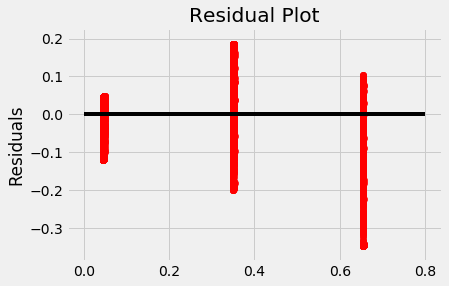

In [288]:
plt.scatter(y_pred_lm5, y_pred_lm5 - y_test, c='r', s=40)
plt.hlines(y=0, xmin=0, xmax=.8)
plt.title("Residual Plot")
plt.ylabel('Residuals')